Processing enemy 5...


C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2711998282.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2711998282.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2711998282.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2711998282.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` ins

Processing enemy 6...
Processing enemy 8...


C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2711998282.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2711998282.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2711998282.py:44: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True, comment='#', header=None)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2711998282.py:44: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future vers

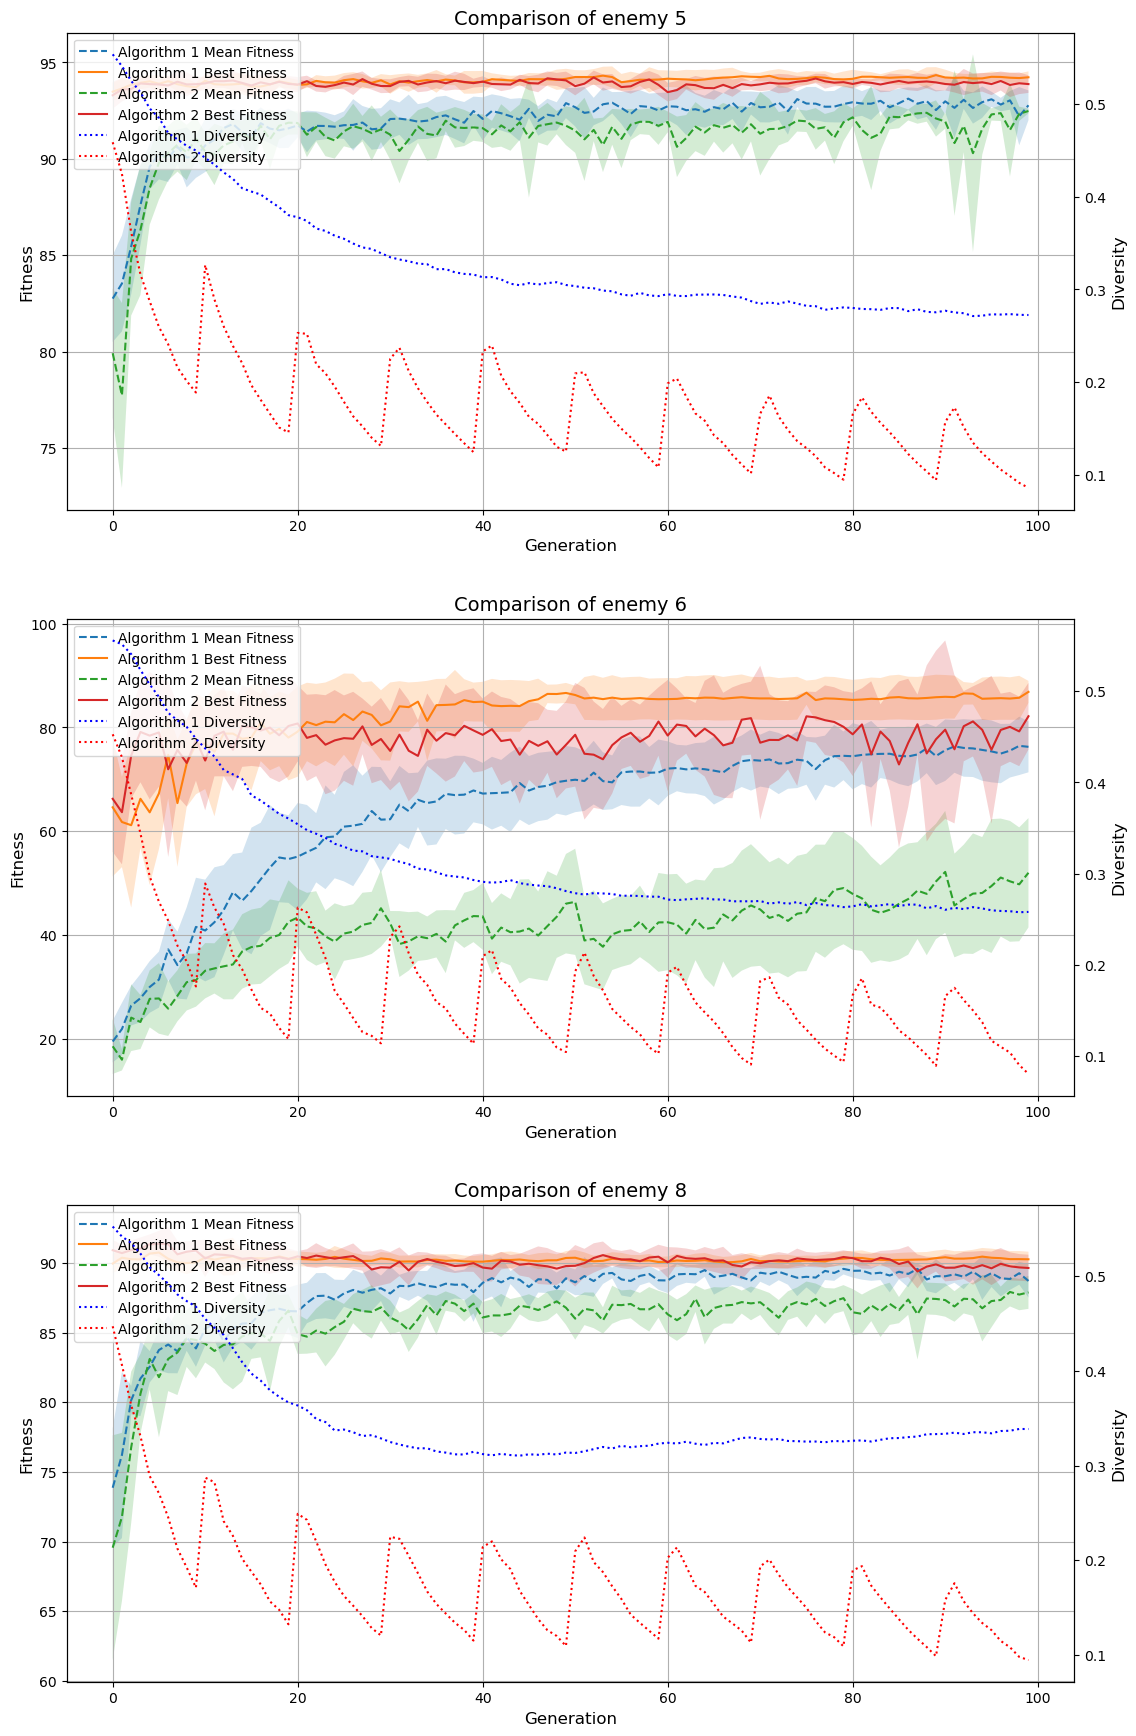

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set manual input for enemies to evaluate (e.g., [5, 6])
enemies_to_evaluate = [5, 6, 8]

# Base directories for both algorithms
algorithm_dirs = {
    'Algorithm 1': 'EA1_line_plot_runs',
    'Algorithm 2': 'EA2_line_plot_runs'
}

def process_results_for_enemy(base_folder, enemy, algorithm):
    """
    Process the results for a given enemy for one algorithm, handling different logging formats.
    """
    enemy_folder = os.path.join(base_folder, f"EN{enemy}")
    
    if not os.path.isdir(enemy_folder):
        print(f"Enemy folder not found: {enemy_folder}")
        return None

    all_dfs = []  # Initialize an empty list to hold dataframes

    # Iterate through the run folders (e.g., run_1_ENX, run_2_ENX, etc.)
    for run_folder in os.listdir(enemy_folder):
        run_path = os.path.join(enemy_folder, run_folder)
        
        if os.path.isdir(run_path):
            result_file = os.path.join(run_path, 'results.txt')  # Each run has a 'results.txt' file
            
            if os.path.exists(result_file):
                # Read results file
                if algorithm == 'Algorithm 1':
                    # For Algorithm 1
                    df = pd.read_csv(result_file, delim_whitespace=True)
                    
                    # Drop the first duplicate generation 0 row (if it exists)
                    df = df.drop_duplicates(subset=['gen'], keep='last')
                    
                elif algorithm == 'Algorithm 2':
                    # For Algorithm 2
                    df = pd.read_csv(result_file, delim_whitespace=True, comment='#', header=None)
                    df.columns = ['gen', 'best', 'mean', 'std', 'diversity']  # Add column names
                    
                    # Convert the 'gen' column to integer since it's stored as float
                    df['gen'] = df['gen'].astype(int)
                    
                # Ensure valid numeric data
                df = df[pd.to_numeric(df['best'], errors='coerce').notnull()]

                # Convert columns to numeric
                df['best'] = pd.to_numeric(df['best'])
                df['mean'] = pd.to_numeric(df['mean'])
                df['std'] = pd.to_numeric(df['std'])
                df['diversity'] = pd.to_numeric(df['diversity'])
                df['gen'] = pd.to_numeric(df['gen'])

                # Append DataFrame to the list
                all_dfs.append(df)

    if all_dfs:
        return pd.concat(all_dfs)  # Return the concatenated dataframe
    return None

def make_subplots_across_enemies(algorithm_dfs_dict, enemies):
    """
    Create subplots with the results for all enemies, with dual y-axes for fitness and diversity.
    """
    n_enemies = len(enemies)  # Number of enemies provided
    fig, axes = plt.subplots(nrows=n_enemies, ncols=1, figsize=(12, 18))

    if n_enemies == 1:
        axes = [axes]  # Handle the case where there's only one enemy to plot

    # Iterate over each enemy and corresponding axis
    for i, (enemy, ax) in enumerate(zip(enemies, axes)):
        algorithm_dfs = algorithm_dfs_dict[enemy]

        # Create a second y-axis for diversity (only once, shared between algorithms)
        ax2 = ax.twinx()

        for algorithm_name, df in algorithm_dfs.items():
            if df is not None:
                # Group by generation and calculate mean and std for mean and best fitness
                grouped_stats = df.groupby('gen').agg(
                    mean_avg_fitness=('mean', 'mean'),
                    std_avg_fitness=('mean', 'std'),
                    mean_max_fitness=('best', 'mean'),
                    std_max_fitness=('best', 'std'),
                    mean_diversity=('diversity', 'mean')
                )

                generations = grouped_stats.index

                # Plot mean fitness with standard deviation shading (left y-axis)
                ax.plot(generations, grouped_stats['mean_avg_fitness'], label=f"{algorithm_name} Mean Fitness", linestyle='--')
                ax.fill_between(generations,
                                grouped_stats['mean_avg_fitness'] - grouped_stats['std_avg_fitness'],
                                grouped_stats['mean_avg_fitness'] + grouped_stats['std_avg_fitness'],
                                alpha=0.2)

                # Plot best fitness with standard deviation shading (left y-axis)
                ax.plot(generations, grouped_stats['mean_max_fitness'], label=f"{algorithm_name} Best Fitness", linestyle='-')
                ax.fill_between(generations,
                                grouped_stats['mean_max_fitness'] - grouped_stats['std_max_fitness'],
                                grouped_stats['mean_max_fitness'] + grouped_stats['std_max_fitness'],
                                alpha=0.2)

                # Plot diversity on the secondary y-axis (right axis)
                if algorithm_name == 'Algorithm 1':
                    ax2.plot(generations, grouped_stats['mean_diversity'], label=f"{algorithm_name} Diversity", linestyle=':', color='blue')
                elif algorithm_name == 'Algorithm 2':
                    ax2.plot(generations, grouped_stats['mean_diversity'], label=f"{algorithm_name} Diversity", linestyle=':', color='red')

        # Customize each subplot
        ax.set_title(f'Comparison of enemy {enemy}', fontsize=14)
        ax.set_xlabel('Generation', fontsize=12)
        ax.set_ylabel('Fitness', fontsize=12)
        ax.grid(True)

        # Customize the second y-axis for diversity
        ax2.set_ylabel('Diversity', fontsize=12)
        ax2.tick_params(axis='y', colors='black')

        # Combine legends from both axes
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper left')

    # Adjust layout and show the full figure
    plt.tight_layout(pad=3.0)
    plt.savefig('line_plots.png')  # Uncomment to save the figure
    plt.show()

def process_and_plot(enemies_to_evaluate, algorithm_dirs):
    """
    Process results for all enemies and both algorithms, and generate plots with dual y-axes.
    """
    algorithm_dfs_dict = {}

    for enemy in enemies_to_evaluate:
        print(f"Processing enemy {enemy}...")

        # Dictionary to hold the dataframes for both algorithms
        algorithm_dfs = {}

        # Process results for both algorithms
        for algorithm_name, base_folder in algorithm_dirs.items():
            df = process_results_for_enemy(base_folder, enemy, algorithm_name)
            algorithm_dfs[algorithm_name] = df
        
        # Store the results for this enemy
        algorithm_dfs_dict[enemy] = algorithm_dfs

    # Generate subplots for all enemies with dual y-axes
    make_subplots_across_enemies(algorithm_dfs_dict, enemies_to_evaluate)

# Main script
if __name__ == "__main__":
    # Process and plot the results for the selected enemies
    process_and_plot(enemies_to_evaluate, algorithm_dirs)


Processing enemy 5...
Processing enemy 6...
Processing enemy 8...


C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2644909053.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2644909053.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2644909053.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\2644909053.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` ins

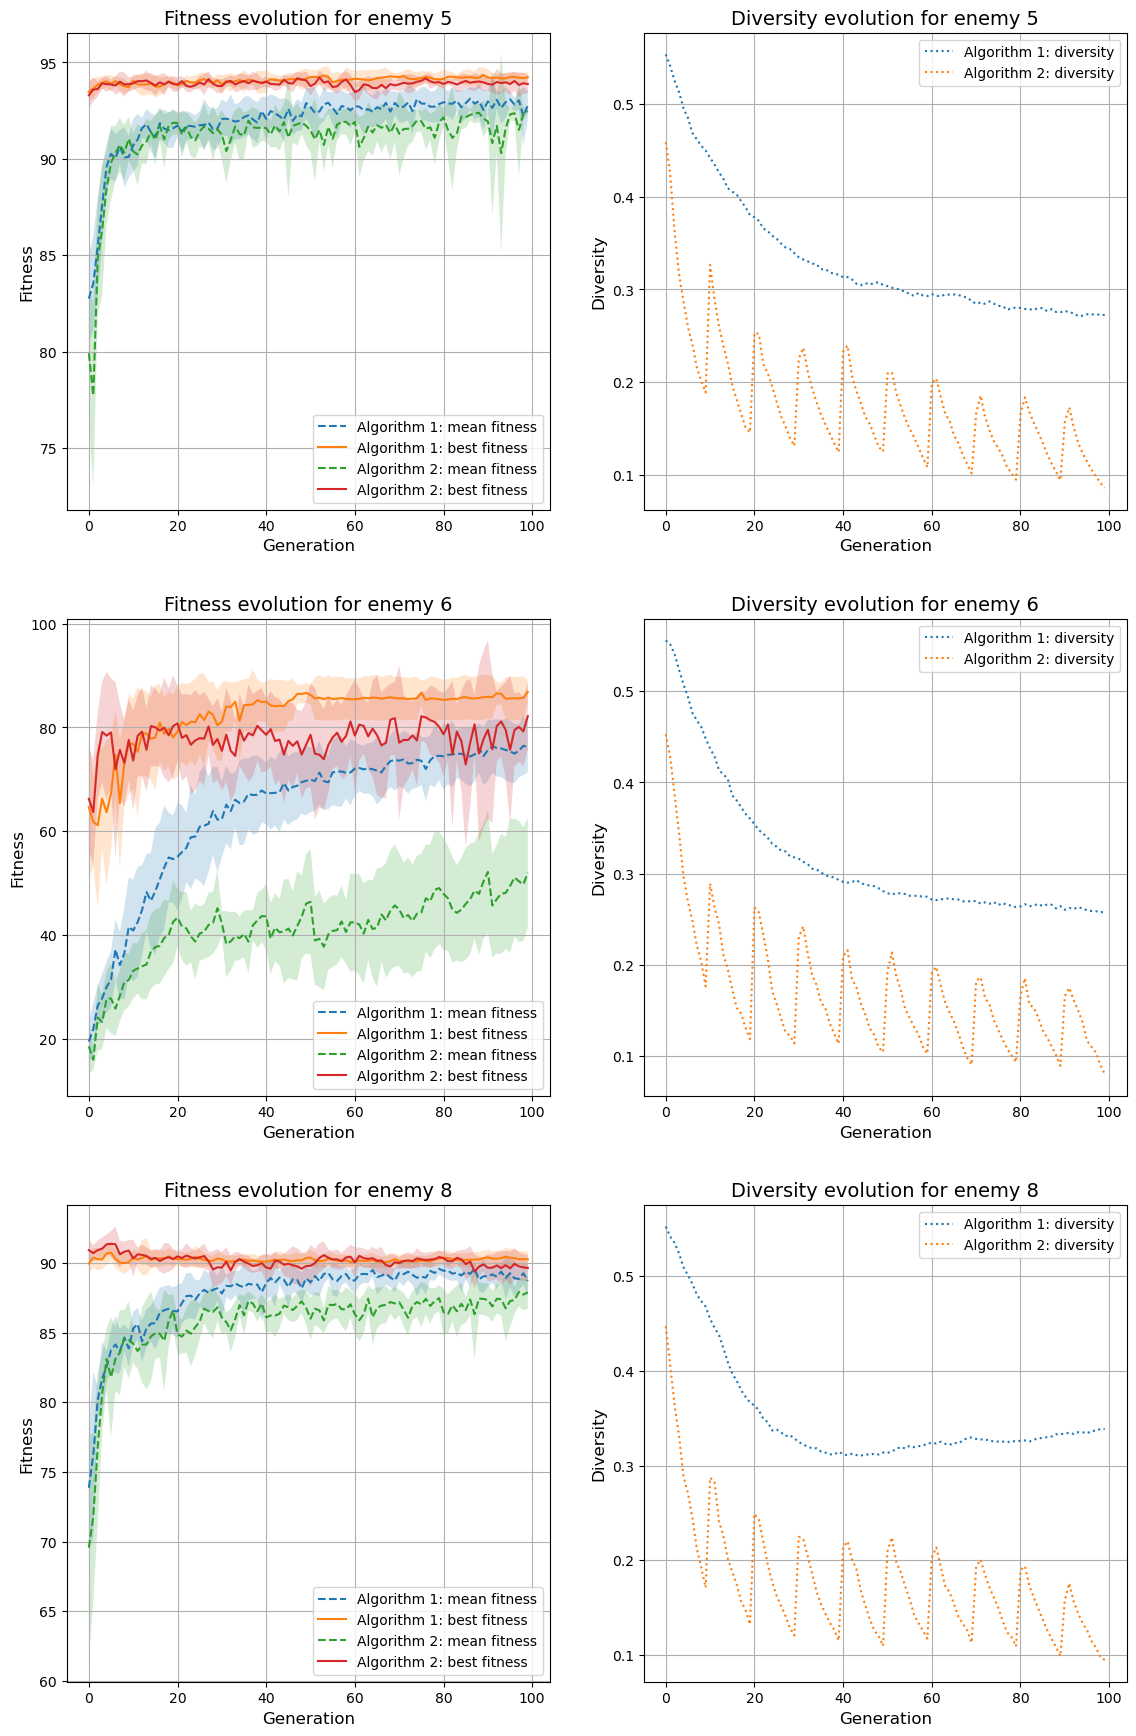

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set manual input for enemies to evaluate (e.g., [5, 6])
enemies_to_evaluate = [5, 6, 8]

# Base directories for both algorithms
algorithm_dirs = {
    'Algorithm 1': 'EA1_line_plot_runs',
    'Algorithm 2': 'EA2_line_plot_runs'
}

def process_results_for_enemy(base_folder, enemy, algorithm):
    """
    Process the results for a given enemy for one algorithm, handling different logging formats.
    """
    enemy_folder = os.path.join(base_folder, f"EN{enemy}")
    
    if not os.path.isdir(enemy_folder):
        print(f"Enemy folder not found: {enemy_folder}")
        return None

    all_dfs = []  # Initialize an empty list to hold dataframes

    # Iterate through the run folders (e.g., run_1_ENX, run_2_ENX, etc.)
    for run_folder in os.listdir(enemy_folder):
        run_path = os.path.join(enemy_folder, run_folder)
        
        if os.path.isdir(run_path):
            result_file = os.path.join(run_path, 'results.txt')  # Each run has a 'results.txt' file
            
            if os.path.exists(result_file):
                # Read results file
                if algorithm == 'Algorithm 1':
                    # For Algorithm 1
                    df = pd.read_csv(result_file, delim_whitespace=True)
                    
                    # Drop the first duplicate generation 0 row (if it exists)
                    df = df.drop_duplicates(subset=['gen'], keep='last')
                    
                elif algorithm == 'Algorithm 2':
                    # For Algorithm 2
                    df = pd.read_csv(result_file, delim_whitespace=True, comment='#', header=None)
                    df.columns = ['gen', 'best', 'mean', 'std', 'diversity']  # Add column names
                    
                    # Convert the 'gen' column to integer since it's stored as float
                    df['gen'] = df['gen'].astype(int)
                    
                # Ensure valid numeric data
                df = df[pd.to_numeric(df['best'], errors='coerce').notnull()]

                # Convert columns to numeric
                df['best'] = pd.to_numeric(df['best'])
                df['mean'] = pd.to_numeric(df['mean'])
                df['std'] = pd.to_numeric(df['std'])
                df['diversity'] = pd.to_numeric(df['diversity'])
                df['gen'] = pd.to_numeric(df['gen'])

                # Append DataFrame to the list
                all_dfs.append(df)

    if all_dfs:
        return pd.concat(all_dfs)  # Return the concatenated dataframe
    return None

def make_subplots_across_enemies(algorithm_dfs_dict, enemies):
    """
    Create subplots with the results for all enemies, with separate plots for fitness and diversity.
    """
    n_enemies = len(enemies)  # Number of enemies provided
    fig, axes = plt.subplots(nrows=n_enemies, ncols=2, figsize=(12, 18))  # Create an n x 2 grid

    if n_enemies == 1:
        axes = [axes]  # Handle the case where there's only one enemy to plot

    # Iterate over each enemy and corresponding axes
    for i, (enemy, ax_pair) in enumerate(zip(enemies, axes)):
        ax_fitness, ax_diversity = ax_pair  # Unpack the axes for fitness and diversity

        algorithm_dfs = algorithm_dfs_dict[enemy]

        for algorithm_name, df in algorithm_dfs.items():
            if df is not None:
                # Group by generation and calculate mean and std for mean and best fitness
                grouped_stats = df.groupby('gen').agg(
                    mean_avg_fitness=('mean', 'mean'),
                    std_avg_fitness=('mean', 'std'),
                    mean_max_fitness=('best', 'mean'),
                    std_max_fitness=('best', 'std'),
                    mean_diversity=('diversity', 'mean')
                )

                generations = grouped_stats.index

                # Plot mean fitness with standard deviation shading on fitness axis
                ax_fitness.plot(generations, grouped_stats['mean_avg_fitness'], label=f"{algorithm_name}: mean fitness", linestyle='--')
                ax_fitness.fill_between(generations,
                                        grouped_stats['mean_avg_fitness'] - grouped_stats['std_avg_fitness'],
                                        grouped_stats['mean_avg_fitness'] + grouped_stats['std_avg_fitness'],
                                        alpha=0.2)

                # Plot best fitness with standard deviation shading on fitness axis
                ax_fitness.plot(generations, grouped_stats['mean_max_fitness'], label=f"{algorithm_name}: best fitness", linestyle='-')
                ax_fitness.fill_between(generations,
                                        grouped_stats['mean_max_fitness'] - grouped_stats['std_max_fitness'],
                                        grouped_stats['mean_max_fitness'] + grouped_stats['std_max_fitness'],
                                        alpha=0.2)

                # Plot diversity on diversity axis
                ax_diversity.plot(generations, grouped_stats['mean_diversity'], label=f"{algorithm_name}: diversity", linestyle=':')

        # Customize the fitness plot (left)
        ax_fitness.set_title(f'Fitness evolution for enemy {enemy}', fontsize=14)
        ax_fitness.set_xlabel('Generation', fontsize=12)
        ax_fitness.set_ylabel('Fitness', fontsize=12)
        ax_fitness.grid(True)

        # Customize the diversity plot (right)
        ax_diversity.set_title(f'Diversity evolution for enemy {enemy}', fontsize=14)
        ax_diversity.set_xlabel('Generation', fontsize=12)
        ax_diversity.set_ylabel('Diversity', fontsize=12)
        ax_diversity.grid(True)
        #ax_diversity.tick_params(axis='y', colors='red')

        # Combine legends for fitness and diversity
        fitness_lines, fitness_labels = ax_fitness.get_legend_handles_labels()
        diversity_lines, diversity_labels = ax_diversity.get_legend_handles_labels()
        ax_fitness.legend(fitness_lines, fitness_labels, loc='lower right')
        ax_diversity.legend(diversity_lines, diversity_labels, loc='upper right')

    # Adjust layout to prevent overlap between subplots
    plt.tight_layout(pad=3.0)
    plt.savefig('line_plots_3x2.png')  # Uncomment to save the figure
    plt.show()

def process_and_plot(enemies_to_evaluate, algorithm_dirs):
    """
    Process results for all enemies and both algorithms, and generate n x 2 subplots for fitness and diversity.
    """
    algorithm_dfs_dict = {}

    for enemy in enemies_to_evaluate:
        print(f"Processing enemy {enemy}...")

        # Dictionary to hold the dataframes for both algorithms
        algorithm_dfs = {}

        # Process results for both algorithms
        for algorithm_name, base_folder in algorithm_dirs.items():
            df = process_results_for_enemy(base_folder, enemy, algorithm_name)
            algorithm_dfs[algorithm_name] = df
        
        # Store the results for this enemy
        algorithm_dfs_dict[enemy] = algorithm_dfs

    # Generate subplots for all enemies with separate fitness and diversity plots
    make_subplots_across_enemies(algorithm_dfs_dict, enemies_to_evaluate)

# Main script
if __name__ == "__main__":
    # Process and plot the results for the selected enemies
    process_and_plot(enemies_to_evaluate, algorithm_dirs)


C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\740995603.py:85: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\740995603.py:85: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\740995603.py:85: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\740995603.py:85: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

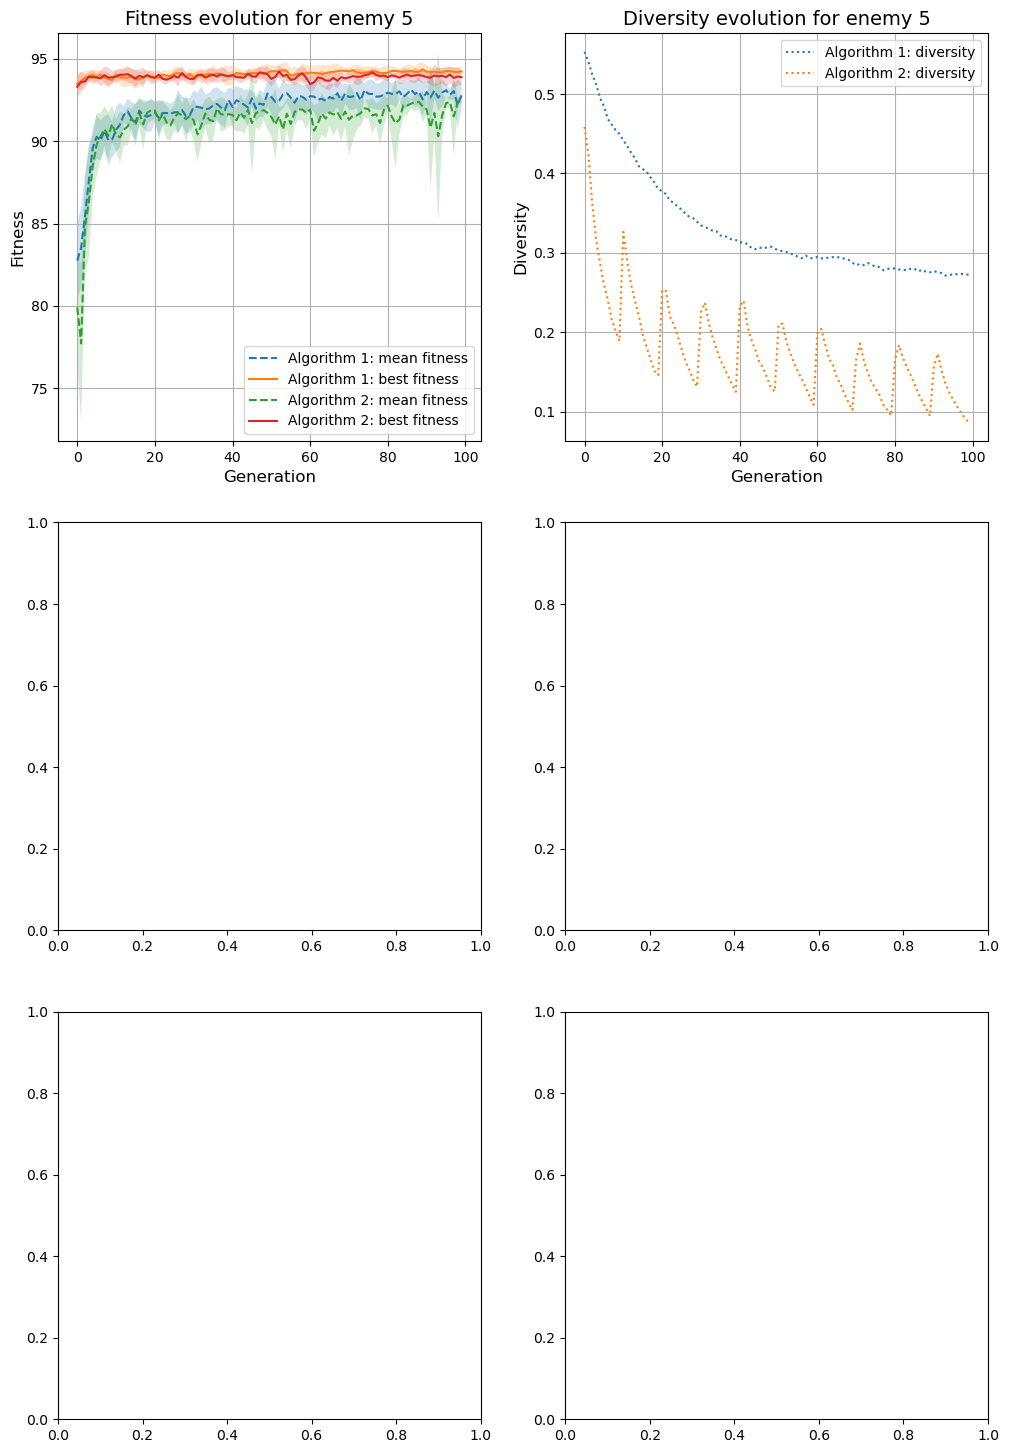

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_rel, wilcoxon
from statsmodels.stats.stattools import durbin_watson

# Set manual input for enemies to evaluate (e.g., [5, 6])
enemies_to_evaluate = [5, 6, 8]

# Base directories for both algorithms
algorithm_dirs = {
    'Algorithm 1': 'EA1_line_plot_runs',
    'Algorithm 2': 'EA2_line_plot_runs'
}

# Statistical test functions
def test_normality(data):
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test Statistic: {stat}, P-value: {p_value}")
    return p_value

def test_autocorrelation(data):
    dw_stat = durbin_watson(data)
    print(f"Durbin-Watson Statistic: {dw_stat}")
    return dw_stat

def test_equal_variance(data1, data2):
    stat, p_value = levene(data1, data2)
    print(f"Levene's Test Statistic: {stat}, P-value: {p_value}")
    return p_value

def compare_datasets(data1, data2):
    # Test for normality
    p_value_normal1 = test_normality(data1)
    p_value_normal2 = test_normality(data2)
    
    # Test for autocorrelation
    dw_stat1 = test_autocorrelation(data1)
    dw_stat2 = test_autocorrelation(data2)
    
    # Test for equal variance
    p_value_equal_variance = test_equal_variance(data1, data2)
    
    # Decide on the test to use
    if p_value_normal1 > 0.05 and p_value_normal2 > 0.05 and 1.5 < dw_stat1 < 2.5 and 1.5 < dw_stat2 < 2.5:
        if p_value_equal_variance > 0.05:
            # Normal, no autocorrelation, and equal variances: use paired t-test
            stat, p_value = ttest_rel(data1, data2)
            print(f"T-test used. T-statistic: {stat}, P-value: {p_value}")
            return "T-test", p_value
        else:
            # Normal, no autocorrelation, but unequal variances: use Wilcoxon Signed-Rank Test
            stat, p_value = wilcoxon(data1, data2)
            print(f"Wilcoxon Signed-Rank Test used due to unequal variances. Test statistic: {stat}, P-value: {p_value}")
            return "Wilcoxon Signed-Rank Test (unequal variances)", p_value
    else:
        # Non-normal or autocorrelated, use Wilcoxon Signed-Rank Test
        stat, p_value = wilcoxon(data1, data2)
        print(f"Wilcoxon Signed-Rank Test used. Test statistic: {stat}, P-value: {p_value}")
        return "Wilcoxon Signed-Rank Test", p_value

def process_results_for_enemy(base_folder, enemy, algorithm):
    """
    Process the results for a given enemy for one algorithm, handling different logging formats.
    """
    enemy_folder = os.path.join(base_folder, f"EN{enemy}")
    
    if not os.path.isdir(enemy_folder):
        print(f"Enemy folder not found: {enemy_folder}")
        return None

    all_dfs = []  # Initialize an empty list to hold dataframes

    # Iterate through the run folders (e.g., run_1_ENX, run_2_ENX, etc.)
    for run_folder in os.listdir(enemy_folder):
        run_path = os.path.join(enemy_folder, run_folder)
        
        if os.path.isdir(run_path):
            result_file = os.path.join(run_path, 'results.txt')  # Each run has a 'results.txt' file
            
            if os.path.exists(result_file):
                # Read results file
                if algorithm == 'Algorithm 1':
                    # For Algorithm 1
                    df = pd.read_csv(result_file, delim_whitespace=True)
                    
                    # Drop the first duplicate generation 0 row (if it exists)
                    df = df.drop_duplicates(subset=['gen'], keep='last')
                    
                elif algorithm == 'Algorithm 2':
                    # For Algorithm 2
                    df = pd.read_csv(result_file, delim_whitespace=True, comment='#', header=None)
                    df.columns = ['gen', 'best', 'mean', 'std', 'diversity']  # Add column names
                    
                    # Convert the 'gen' column to integer since it's stored as float
                    df['gen'] = df['gen'].astype(int)
                    
                # Ensure valid numeric data
                df = df[pd.to_numeric(df['best'], errors='coerce').notnull()]

                # Convert columns to numeric
                df['best'] = pd.to_numeric(df['best'])
                df['mean'] = pd.to_numeric(df['mean'])
                df['std'] = pd.to_numeric(df['std'])
                df['diversity'] = pd.to_numeric(df['diversity'])
                df['gen'] = pd.to_numeric(df['gen'])

                # Append DataFrame to the list
                all_dfs.append(df)

    if all_dfs:
        return pd.concat(all_dfs)  # Return the concatenated dataframe
    return None

def make_subplots_across_enemies(algorithm_dfs_dict, enemies):
    """
    Create subplots with the results for all enemies, with separate plots for fitness and diversity.
    """
    n_enemies = len(enemies)  # Number of enemies provided
    fig, axes = plt.subplots(nrows=n_enemies, ncols=2, figsize=(12, 18))  # Create an n x 2 grid

    if n_enemies == 1:
        axes = [axes]  # Handle the case where there's only one enemy to plot

    # Iterate over each enemy and corresponding axes
    for i, (enemy, ax_pair) in enumerate(zip(enemies, axes)):
        ax_fitness, ax_diversity = ax_pair  # Unpack the axes for fitness and diversity

        algorithm_dfs = algorithm_dfs_dict[enemy]

        # Extract lists to hold the mean best fitness values for statistical testing
        algo1_best_fitness = []
        algo2_best_fitness = []

        for algorithm_name, df in algorithm_dfs.items():
            if df is not None:
                # Group by generation and calculate mean and std for mean and best fitness
                grouped_stats = df.groupby('gen').agg(
                    mean_avg_fitness=('mean', 'mean'),
                    std_avg_fitness=('mean', 'std'),
                    mean_max_fitness=('best', 'mean'),
                    std_max_fitness=('best', 'std'),
                    mean_diversity=('diversity', 'mean')
                )

                generations = grouped_stats.index

                # Plot mean fitness with standard deviation shading on fitness axis
                ax_fitness.plot(generations, grouped_stats['mean_avg_fitness'], label=f"{algorithm_name}: mean fitness", linestyle='--')
                ax_fitness.fill_between(generations,
                                        grouped_stats['mean_avg_fitness'] - grouped_stats['std_avg_fitness'],
                                        grouped_stats['mean_avg_fitness'] + grouped_stats['std_avg_fitness'],
                                        alpha=0.2)

                # Plot best fitness with standard deviation shading on fitness axis
                ax_fitness.plot(generations, grouped_stats['mean_max_fitness'], label=f"{algorithm_name}: best fitness", linestyle='-')
                ax_fitness.fill_between(generations,
                                        grouped_stats['mean_max_fitness'] - grouped_stats['std_max_fitness'],
                                        grouped_stats['mean_max_fitness'] + grouped_stats['std_max_fitness'],
                                        alpha=0.2)

                # Collect best fitness values for statistical comparison
                if algorithm_name == 'Algorithm 1':
                    algo1_best_fitness = grouped_stats['mean_max_fitness'].values
                elif algorithm_name == 'Algorithm 2':
                    algo2_best_fitness = grouped_stats['mean_max_fitness'].values

                # Plot diversity on diversity axis
                ax_diversity.plot(generations, grouped_stats['mean_diversity'], label=f"{algorithm_name}: diversity", linestyle=':')

        # Customize the fitness plot (left)
        ax_fitness.set_title(f'Fitness evolution for enemy {enemy}', fontsize=14)
        ax_fitness.set_xlabel('Generation', fontsize=12)
        ax_fitness.set_ylabel('Fitness', fontsize=12)
        ax_fitness.grid(True)

        # Customize the diversity plot (right)
        ax_diversity.set_title(f'Diversity evolution for enemy {enemy}', fontsize=14)
        ax_diversity.set_xlabel('Generation', fontsize=12)
        ax_diversity.set_ylabel('Diversity', fontsize=12)
        ax_diversity.grid(True)

        # Combine legends for fitness and diversity
        fitness_lines, fitness_labels = ax_fitness.get_legend_handles_labels()
        diversity_lines, diversity_labels = ax_diversity.get_legend_handles_labels()
        ax_fitness.legend(fitness_lines, fitness_labels, loc='lower right')
        ax_diversity.legend(diversity_lines, diversity_labels, loc='upper right')

        # Perform statistical comparison between the two algorithms' best fitness values
        if algo1_best_fitness and algo2_best_fitness:
            test_name, p_value = compare_datasets(np.array(algo1_best_fitness), np.array(algo2_best_fitness))
            print(f"For Enemy {enemy}, {test_name} was used with a p-value of {p_value:.4f}")

    plt.tight_layout()
    plt.show()

# Main execution to process results and plot them
if __name__ == "__main__":
    results_per_enemy = {}

    # Process each enemy for both algorithms
    for enemy in enemies_to_evaluate:
        algorithm_dfs = {}
        for algorithm_name, base_dir in algorithm_dirs.items():
            df = process_results_for_enemy(base_dir, enemy, algorithm_name)
            algorithm_dfs[algorithm_name] = df

        # Store processed data for plotting and statistical testing
        results_per_enemy[enemy] = algorithm_dfs

    # Create the plots and perform statistical comparisons
    make_subplots_across_enemies(results_per_enemy, enemies_to_evaluate)


Processing enemy 5...
Processing enemy 6...
Processing enemy 8...


C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\3973577382.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\3973577382.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\3973577382.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\3973577382.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` ins

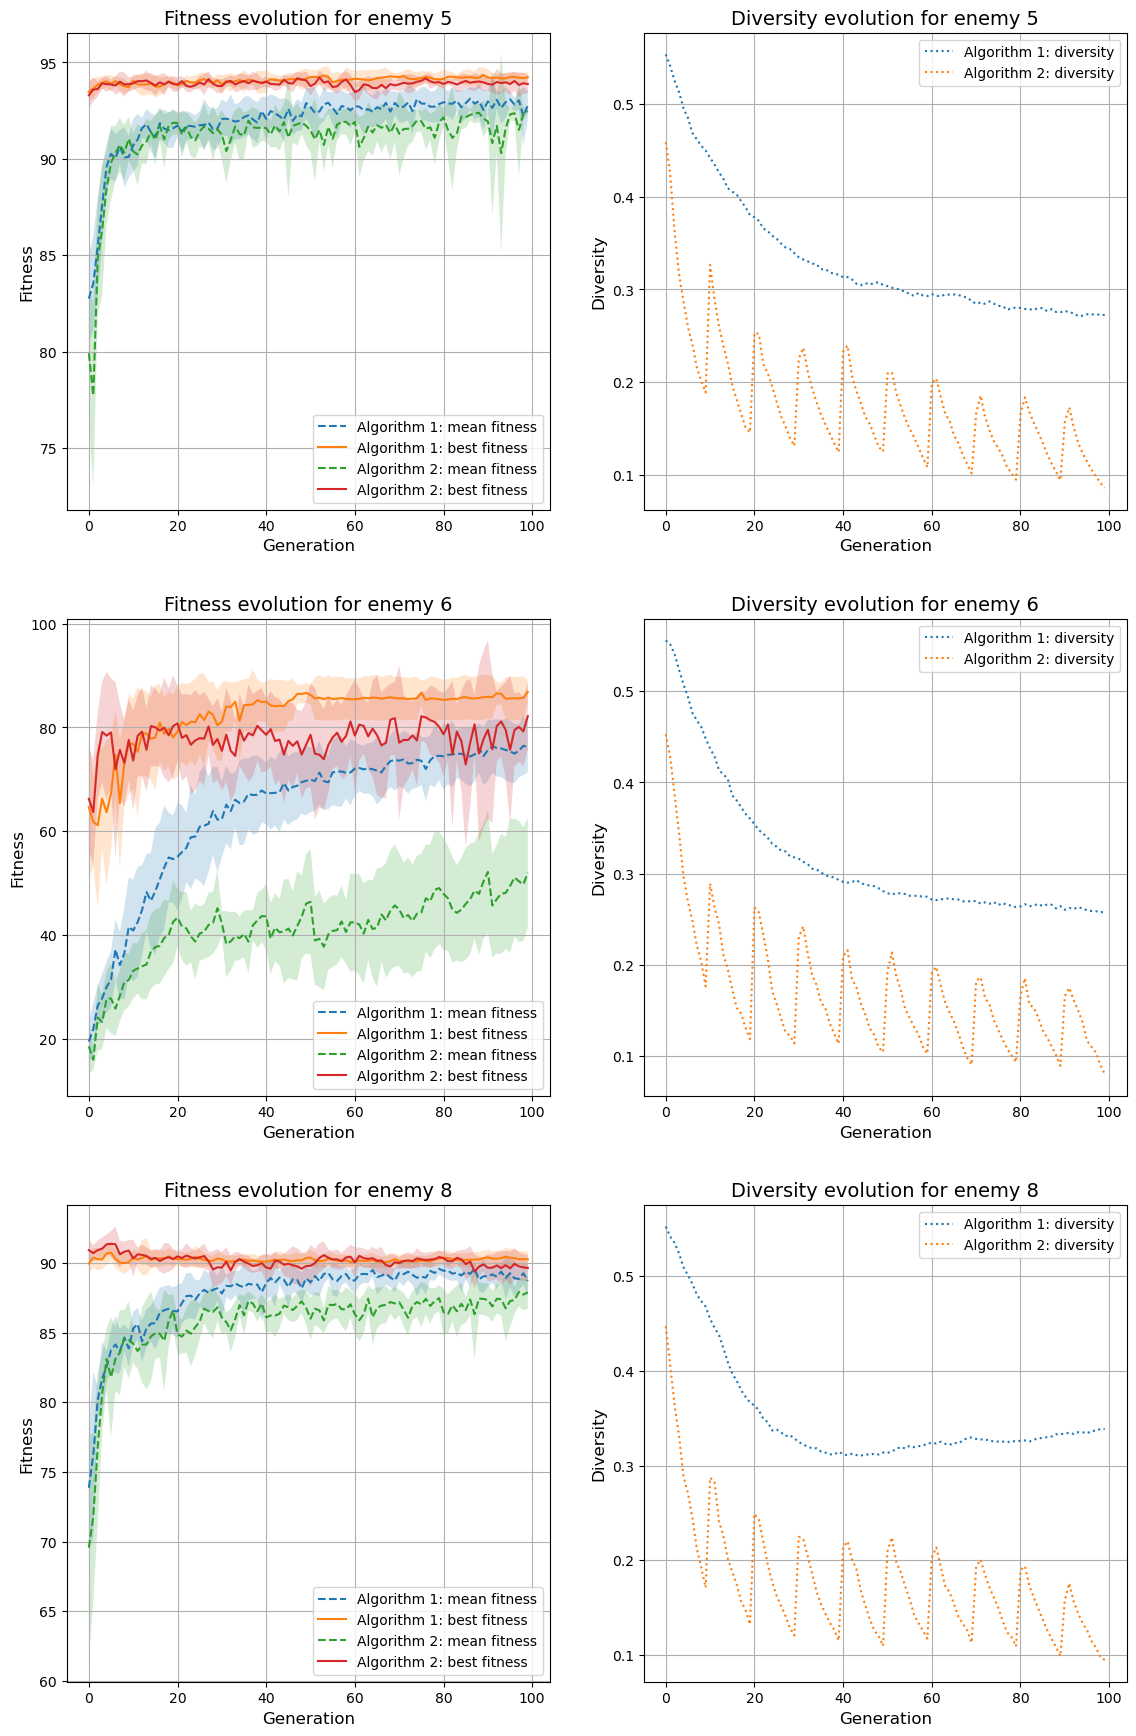


Statistical comparison for Enemy 5:
Shapiro-Wilk Test Statistic: 0.9195953452358165, P-value: 1.205993670924728e-22
Shapiro-Wilk Test Statistic: 0.9637564783344931, P-value: 4.612644789375421e-15
Durbin-Watson Statistic: 8.949953830605787e-06
Durbin-Watson Statistic: 2.2901850138344046e-05
Levene's Test Statistic: 1.044312841652107, P-value: 0.3069442511706493
Wilcoxon Signed-Rank Test used. Test statistic: 149659.0, P-value: 9.881862195575851e-27

Statistical comparison for Enemy 6:
Shapiro-Wilk Test Statistic: 0.7418193717924395, P-value: 9.101230109188787e-37
Shapiro-Wilk Test Statistic: 0.8262413822879826, P-value: 1.4326384117356039e-31
Durbin-Watson Statistic: 0.005528411061987003
Durbin-Watson Statistic: 0.012098334843780277
Levene's Test Statistic: 60.07930337887211, P-value: 1.4396541536099895e-14
Wilcoxon Signed-Rank Test used. Test statistic: 129256.0, P-value: 4.868198134529701e-40

Statistical comparison for Enemy 8:
Shapiro-Wilk Test Statistic: 0.8335397499130834, P-valu

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_rel, wilcoxon
from statsmodels.stats.stattools import durbin_watson

# Set manual input for enemies to evaluate (e.g., [5, 6])
enemies_to_evaluate = [5, 6, 8]

# Base directories for both algorithms
algorithm_dirs = {
    'Algorithm 1': 'EA1_line_plot_runs',
    'Algorithm 2': 'EA2_line_plot_runs'
}

def process_results_for_enemy(base_folder, enemy, algorithm):
    """
    Process the results for a given enemy for one algorithm, handling different logging formats.
    """
    enemy_folder = os.path.join(base_folder, f"EN{enemy}")
    
    if not os.path.isdir(enemy_folder):
        print(f"Enemy folder not found: {enemy_folder}")
        return None

    all_dfs = []  # Initialize an empty list to hold dataframes

    # Iterate through the run folders (e.g., run_1_ENX, run_2_ENX, etc.)
    for run_folder in os.listdir(enemy_folder):
        run_path = os.path.join(enemy_folder, run_folder)
        
        if os.path.isdir(run_path):
            result_file = os.path.join(run_path, 'results.txt')  # Each run has a 'results.txt' file
            
            if os.path.exists(result_file):
                # Read results file
                if algorithm == 'Algorithm 1':
                    # For Algorithm 1
                    df = pd.read_csv(result_file, delim_whitespace=True)
                    
                    # Drop the first duplicate generation 0 row (if it exists)
                    df = df.drop_duplicates(subset=['gen'], keep='last')
                    
                elif algorithm == 'Algorithm 2':
                    # For Algorithm 2
                    df = pd.read_csv(result_file, delim_whitespace=True, comment='#', header=None)
                    df.columns = ['gen', 'best', 'mean', 'std', 'diversity']  # Add column names
                    
                    # Convert the 'gen' column to integer since it's stored as float
                    df['gen'] = df['gen'].astype(int)
                    
                # Ensure valid numeric data
                df = df[pd.to_numeric(df['best'], errors='coerce').notnull()]

                # Convert columns to numeric
                df['best'] = pd.to_numeric(df['best'])
                df['mean'] = pd.to_numeric(df['mean'])
                df['std'] = pd.to_numeric(df['std'])
                df['diversity'] = pd.to_numeric(df['diversity'])
                df['gen'] = pd.to_numeric(df['gen'])

                # Append DataFrame to the list
                all_dfs.append(df)

    if all_dfs:
        return pd.concat(all_dfs)  # Return the concatenated dataframe
    return None

def make_subplots_across_enemies(algorithm_dfs_dict, enemies):
    """
    Create subplots with the results for all enemies, with separate plots for fitness and diversity.
    """
    n_enemies = len(enemies)  # Number of enemies provided
    fig, axes = plt.subplots(nrows=n_enemies, ncols=2, figsize=(12, 18))  # Create an n x 2 grid

    if n_enemies == 1:
        axes = [axes]  # Handle the case where there's only one enemy to plot

    # Iterate over each enemy and corresponding axes
    for i, (enemy, ax_pair) in enumerate(zip(enemies, axes)):
        ax_fitness, ax_diversity = ax_pair  # Unpack the axes for fitness and diversity

        algorithm_dfs = algorithm_dfs_dict[enemy]

        for algorithm_name, df in algorithm_dfs.items():
            if df is not None:
                # Group by generation and calculate mean and std for mean and best fitness
                grouped_stats = df.groupby('gen').agg(
                    mean_avg_fitness=('mean', 'mean'),
                    std_avg_fitness=('mean', 'std'),
                    mean_max_fitness=('best', 'mean'),
                    std_max_fitness=('best', 'std'),
                    mean_diversity=('diversity', 'mean')
                )

                generations = grouped_stats.index

                # Plot mean fitness with standard deviation shading on fitness axis
                ax_fitness.plot(generations, grouped_stats['mean_avg_fitness'], label=f"{algorithm_name}: mean fitness", linestyle='--')
                ax_fitness.fill_between(generations,
                                        grouped_stats['mean_avg_fitness'] - grouped_stats['std_avg_fitness'],
                                        grouped_stats['mean_avg_fitness'] + grouped_stats['std_avg_fitness'],
                                        alpha=0.2)

                # Plot best fitness with standard deviation shading on fitness axis
                ax_fitness.plot(generations, grouped_stats['mean_max_fitness'], label=f"{algorithm_name}: best fitness", linestyle='-')
                ax_fitness.fill_between(generations,
                                        grouped_stats['mean_max_fitness'] - grouped_stats['std_max_fitness'],
                                        grouped_stats['mean_max_fitness'] + grouped_stats['std_max_fitness'],
                                        alpha=0.2)

                # Plot diversity on diversity axis
                ax_diversity.plot(generations, grouped_stats['mean_diversity'], label=f"{algorithm_name}: diversity", linestyle=':')

        # Customize the fitness plot (left)
        ax_fitness.set_title(f'Fitness evolution for enemy {enemy}', fontsize=14)
        ax_fitness.set_xlabel('Generation', fontsize=12)
        ax_fitness.set_ylabel('Fitness', fontsize=12)
        ax_fitness.grid(True)

        # Customize the diversity plot (right)
        ax_diversity.set_title(f'Diversity evolution for enemy {enemy}', fontsize=14)
        ax_diversity.set_xlabel('Generation', fontsize=12)
        ax_diversity.set_ylabel('Diversity', fontsize=12)
        ax_diversity.grid(True)

        # Combine legends for fitness and diversity
        fitness_lines, fitness_labels = ax_fitness.get_legend_handles_labels()
        diversity_lines, diversity_labels = ax_diversity.get_legend_handles_labels()
        ax_fitness.legend(fitness_lines, fitness_labels, loc='lower right')
        ax_diversity.legend(diversity_lines, diversity_labels, loc='upper right')

    # Adjust layout to prevent overlap between subplots
    plt.tight_layout(pad=3.0)
    plt.savefig('line_plots_3x2.png')  # Uncomment to save the figure
    plt.show()

def test_normality(data):
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test Statistic: {stat}, P-value: {p_value}")
    return p_value

def test_autocorrelation(data):
    dw_stat = durbin_watson(data)
    print(f"Durbin-Watson Statistic: {dw_stat}")
    return dw_stat

def test_equal_variance(data1, data2):
    stat, p_value = levene(data1, data2)
    print(f"Levene's Test Statistic: {stat}, P-value: {p_value}")
    return p_value

def compare_datasets(data1, data2):
    p_value_normal1 = test_normality(data1)
    p_value_normal2 = test_normality(data2)
    
    dw_stat1 = test_autocorrelation(data1)
    dw_stat2 = test_autocorrelation(data2)
    
    p_value_equal_variance = test_equal_variance(data1, data2)
    
    if p_value_normal1 > 0.05 and p_value_normal2 > 0.05 and 1.5 < dw_stat1 < 2.5 and 1.5 < dw_stat2 < 2.5:
        if p_value_equal_variance > 0.05:
            stat, p_value = ttest_rel(data1, data2)
            print(f"T-test used. T-statistic: {stat}, P-value: {p_value}")
            return "T-test", p_value
        else:
            stat, p_value = wilcoxon(data1, data2)
            print(f"Wilcoxon Signed-Rank Test used due to unequal variances. Test statistic: {stat}, P-value: {p_value}")
            return "Wilcoxon Signed-Rank Test (unequal variances)", p_value
    else:
        stat, p_value = wilcoxon(data1, data2)
        print(f"Wilcoxon Signed-Rank Test used. Test statistic: {stat}, P-value: {p_value}")
        return "Wilcoxon Signed-Rank Test", p_value

def process_and_plot_with_stats(enemies_to_evaluate, algorithm_dirs):
    algorithm_dfs_dict = {}

    for enemy in enemies_to_evaluate:
        print(f"Processing enemy {enemy}...")

        algorithm_dfs = {}

        for algorithm_name, base_folder in algorithm_dirs.items():
            df = process_results_for_enemy(base_folder, enemy, algorithm_name)
            algorithm_dfs[algorithm_name] = df
        
        algorithm_dfs_dict[enemy] = algorithm_dfs

    # Plot the fitness and diversity evolution
    make_subplots_across_enemies(algorithm_dfs_dict, enemies_to_evaluate)
    
    # Statistical comparison
    for enemy in enemies_to_evaluate:
        print(f"\nStatistical comparison for Enemy {enemy}:")
        algo1_data = algorithm_dfs_dict[enemy]['Algorithm 1']['best']
        algo2_data = algorithm_dfs_dict[enemy]['Algorithm 2']['best']
        compare_datasets(algo1_data, algo2_data)

if __name__ == "__main__":
    process_and_plot_with_stats(enemies_to_evaluate, algorithm_dirs)


Processing enemy 5...
Processing enemy 6...
Processing enemy 8...


C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\1977592730.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\1977592730.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\1977592730.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(result_file, delim_whitespace=True)
C:\Users\rickg\AppData\Local\Temp\ipykernel_16496\1977592730.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` ins

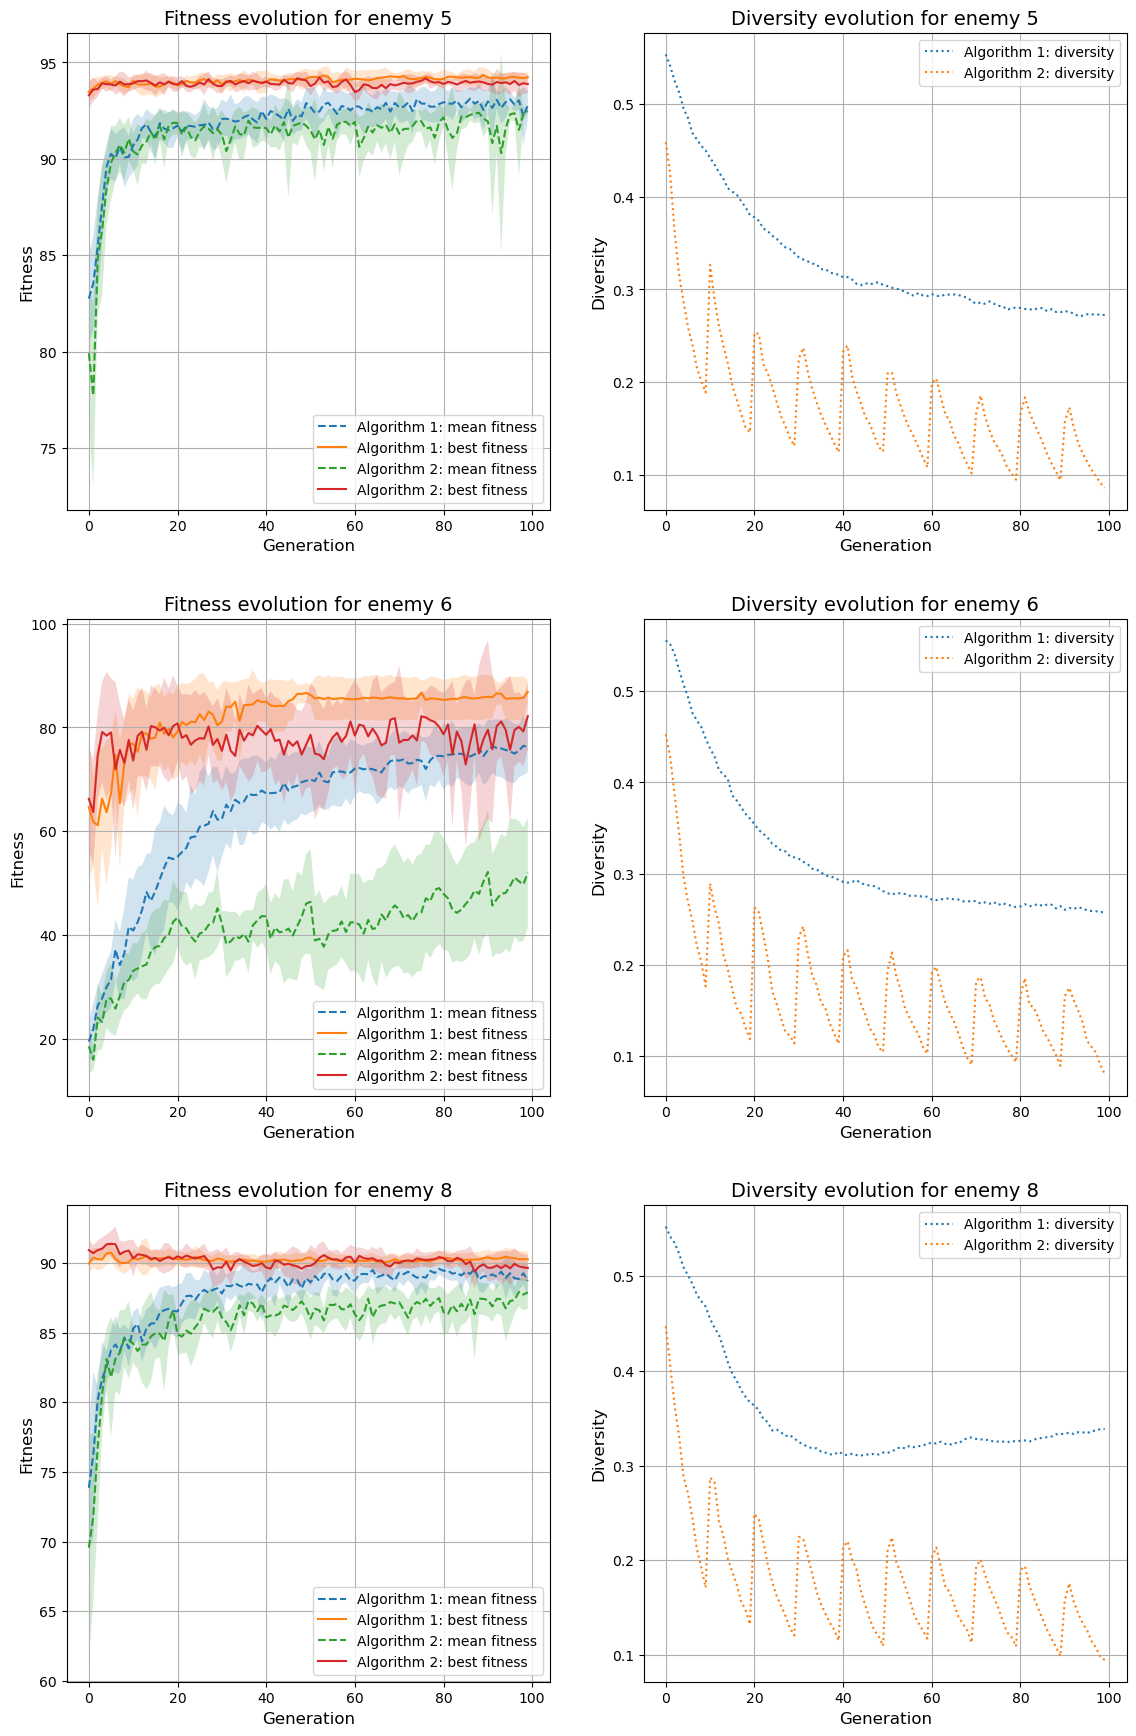


Processing statistical tests for enemy 5...

The statistics for the mean best fitness for enemy 5 are:
Shapiro-Wilk Test Statistic: 0.9341230470339452, P-value: 8.596310617931885e-05
Shapiro-Wilk Test Statistic: 0.9369545118635938, P-value: 0.00012630711547470392
Durbin-Watson Statistic: 9.43110170685132e-07
Durbin-Watson Statistic: 2.379904627777183e-06
Levene's Test Statistic: 2.0203805075683445, P-value: 0.15677335649246316
Wilcoxon Signed-Rank Test used. Test statistic: 480.0, P-value: 2.0450905226320243e-12

The statistics for the mean diversity for enemy 5 are:
Shapiro-Wilk Test Statistic: 0.7881485251904492, P-value: 1.0883481474928388e-10
Shapiro-Wilk Test Statistic: 0.8697138961286954, P-value: 6.826429136160418e-08
Durbin-Watson Statistic: 0.0002076299131726918
Durbin-Watson Statistic: 0.03013655042953045
Levene's Test Statistic: 0.007123840046879216, P-value: 0.9328214230489018
Wilcoxon Signed-Rank Test used. Test statistic: 0.0, P-value: 3.896559845095909e-18

Processing s

In [51]:
#FINAL SCRIPT:

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_rel, wilcoxon
import numpy as np
from statsmodels.stats.stattools import durbin_watson

# Set manual input for enemies to evaluate (e.g., [5, 6])
enemies_to_evaluate = [5, 6, 8]

# Base directories for both algorithms
algorithm_dirs = {
    'Algorithm 1': 'EA1_line_plot_runs',
    'Algorithm 2': 'EA2_line_plot_runs'
}

def process_results_for_enemy(base_folder, enemy, algorithm):
    """
    Process the results for a given enemy for one algorithm, handling different logging formats.
    """
    enemy_folder = os.path.join(base_folder, f"EN{enemy}")
    
    if not os.path.isdir(enemy_folder):
        print(f"Enemy folder not found: {enemy_folder}")
        return None

    all_dfs = []  # Initialize an empty list to hold dataframes

    # Iterate through the run folders (e.g., run_1_ENX, run_2_ENX, etc.)
    for run_folder in os.listdir(enemy_folder):
        run_path = os.path.join(enemy_folder, run_folder)
        
        if os.path.isdir(run_path):
            result_file = os.path.join(run_path, 'results.txt')  # Each run has a 'results.txt' file
            
            if os.path.exists(result_file):
                # Read results file
                if algorithm == 'Algorithm 1':
                    # For Algorithm 1
                    df = pd.read_csv(result_file, delim_whitespace=True)
                    
                    # Drop the first duplicate generation 0 row (if it exists)
                    df = df.drop_duplicates(subset=['gen'], keep='last')
                    
                elif algorithm == 'Algorithm 2':
                    # For Algorithm 2
                    df = pd.read_csv(result_file, delim_whitespace=True, comment='#', header=None)
                    df.columns = ['gen', 'best', 'mean', 'std', 'diversity']  # Add column names
                    
                    # Convert the 'gen' column to integer since it's stored as float
                    df['gen'] = df['gen'].astype(int)
                    
                # Ensure valid numeric data
                df = df[pd.to_numeric(df['best'], errors='coerce').notnull()]

                # Convert columns to numeric
                df['best'] = pd.to_numeric(df['best'])
                df['mean'] = pd.to_numeric(df['mean'])
                df['std'] = pd.to_numeric(df['std'])
                df['diversity'] = pd.to_numeric(df['diversity'])
                df['gen'] = pd.to_numeric(df['gen'])

                # Append DataFrame to the list
                all_dfs.append(df)

    if all_dfs:
        return pd.concat(all_dfs)  # Return the concatenated dataframe
    return None

def make_subplots_across_enemies(algorithm_dfs_dict, enemies):
    """
    Create subplots with the results for all enemies, with separate plots for fitness and diversity.
    """
    n_enemies = len(enemies)  # Number of enemies provided
    fig, axes = plt.subplots(nrows=n_enemies, ncols=2, figsize=(12, 18))  # Create an n x 2 grid

    if n_enemies == 1:
        axes = [axes]  # Handle the case where there's only one enemy to plot

    # Iterate over each enemy and corresponding axes
    for i, (enemy, ax_pair) in enumerate(zip(enemies, axes)):
        ax_fitness, ax_diversity = ax_pair  # Unpack the axes for fitness and diversity

        algorithm_dfs = algorithm_dfs_dict[enemy]

        for algorithm_name, df in algorithm_dfs.items():
            if df is not None:
                # Group by generation and calculate mean and std for mean and best fitness
                grouped_stats = df.groupby('gen').agg(
                    mean_avg_fitness=('mean', 'mean'),
                    std_avg_fitness=('mean', 'std'),
                    mean_max_fitness=('best', 'mean'),
                    std_max_fitness=('best', 'std'),
                    mean_diversity=('diversity', 'mean')
                )

                generations = grouped_stats.index

                # Plot mean fitness with standard deviation shading on fitness axis
                ax_fitness.plot(generations, grouped_stats['mean_avg_fitness'], label=f"{algorithm_name}: mean fitness", linestyle='--')
                ax_fitness.fill_between(generations,
                                        grouped_stats['mean_avg_fitness'] - grouped_stats['std_avg_fitness'],
                                        grouped_stats['mean_avg_fitness'] + grouped_stats['std_avg_fitness'],
                                        alpha=0.2)

                # Plot best fitness with standard deviation shading on fitness axis
                ax_fitness.plot(generations, grouped_stats['mean_max_fitness'], label=f"{algorithm_name}: best fitness", linestyle='-')
                ax_fitness.fill_between(generations,
                                        grouped_stats['mean_max_fitness'] - grouped_stats['std_max_fitness'],
                                        grouped_stats['mean_max_fitness'] + grouped_stats['std_max_fitness'],
                                        alpha=0.2)

                # Plot diversity on diversity axis
                ax_diversity.plot(generations, grouped_stats['mean_diversity'], label=f"{algorithm_name}: diversity", linestyle=':')

        # Customize the fitness plot (left)
        ax_fitness.set_title(f'Fitness evolution for enemy {enemy}', fontsize=14)
        ax_fitness.set_xlabel('Generation', fontsize=12)
        ax_fitness.set_ylabel('Fitness', fontsize=12)
        ax_fitness.grid(True)

        # Customize the diversity plot (right)
        ax_diversity.set_title(f'Diversity evolution for enemy {enemy}', fontsize=14)
        ax_diversity.set_xlabel('Generation', fontsize=12)
        ax_diversity.set_ylabel('Diversity', fontsize=12)
        ax_diversity.grid(True)
        #ax_diversity.tick_params(axis='y', colors='red')

        # Combine legends for fitness and diversity
        fitness_lines, fitness_labels = ax_fitness.get_legend_handles_labels()
        diversity_lines, diversity_labels = ax_diversity.get_legend_handles_labels()
        ax_fitness.legend(fitness_lines, fitness_labels, loc='lower right')
        ax_diversity.legend(diversity_lines, diversity_labels, loc='upper right')

    # Adjust layout to prevent overlap between subplots
    plt.tight_layout(pad=3.0)
    plt.savefig('line_plots_3x2.png')  # Uncomment to save the figure
    plt.show()

def process_across_enemies(enemies_to_evaluate, algorithm_dirs):
    """
    Process results for all enemies and both algorithms, and generate n x 2 subplots for fitness and diversity.
    """
    algorithm_dfs_dict = {}

    for enemy in enemies_to_evaluate:
        print(f"Processing enemy {enemy}...")

        # Dictionary to hold the dataframes for both algorithms
        algorithm_dfs = {}

        # Process results for both algorithms
        for algorithm_name, base_folder in algorithm_dirs.items():
            df = process_results_for_enemy(base_folder, enemy, algorithm_name)
            algorithm_dfs[algorithm_name] = df
        
        # Store the results for this enemy
        algorithm_dfs_dict[enemy] = algorithm_dfs

    return algorithm_dfs_dict

def test_normality(data):
    """
    Test if the small dataset (n<50) is normally distributed using the Shapiro-Wilk test.
    
    Parameters:
    The dataset to test.

    Returns:
    The p-value of the Shapiro-Wilk test.
    """

    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test Statistic: {stat}, P-value: {p_value}")
    return p_value

def test_autocorrelation(data):
    """
    Test if the dataset has significant autocorrelation using the Durbin-Watson test.
    
    Parameters:
    The dataset to test.
    
    Returns:
    Durbin-Watson statistic.
    """

    dw_stat = durbin_watson(data)
    print(f"Durbin-Watson Statistic: {dw_stat}")
    return dw_stat

def test_equal_variance(data1, data2):
    """
    Test if two datasets have equal variances using Levene's test.
    
    Parameters:
    The two datasets to test.
    
    Returns:
    The p-value of Levene's test.
    """
    stat, p_value = levene(data1, data2)
    print(f"Levene's Test Statistic: {stat}, P-value: {p_value}")
    return p_value

def compare_datasets(data1, data2):
    """
    Compare two datasets using t-test or Wilcoxon Signed-Rank Test based on normality, autocorrelation, and equal variance.
    
    Parameters:
    The two datasets to compare
    
    Returns:
    The test used and the p-value.
    """
    # Test for normality
    p_value_normal1 = test_normality(data1)
    p_value_normal2 = test_normality(data2)
    
    # Test for autocorrelation
    dw_stat1 = test_autocorrelation(data1)
    dw_stat2 = test_autocorrelation(data2)
    
    # Test for equal variance
    p_value_equal_variance = test_equal_variance(data1, data2)
    
    # Decide on the test to use
    if p_value_normal1 > 0.05 and p_value_normal2 > 0.05 and 1.5 < dw_stat1 < 2.5 and 1.5 < dw_stat2 < 2.5:
        if p_value_equal_variance > 0.05:
            # Normal, no autocorrelation, and equal variances: use paired t-test
            stat, p_value = ttest_rel(data1, data2)
            print(f"T-test used. T-statistic: {stat}, P-value: {p_value}")
            return "T-test", p_value
        else:
            # Normal, no autocorrelation, but unequal variances: use Wilcoxon Signed-Rank Test
            stat, p_value = wilcoxon(data1, data2)
            print(f"Wilcoxon Signed-Rank Test used due to unequal variances. Test statistic: {stat}, P-value: {p_value}")
            return "Wilcoxon Signed-Rank Test (unequal variances)", p_value
    else:
        # Non-normal or autocorrelated, use Wilcoxon Signed-Rank Test
        stat, p_value = wilcoxon(data1, data2)
        print(f"Wilcoxon Signed-Rank Test used. Test statistic: {stat}, P-value: {p_value}")
        return "Wilcoxon Signed-Rank Test", p_value

def perform_stats_test(algorithm_dfs_dict, enemies):
    """
    Perform statistical tests on the mean best fitness and mean diversity for each enemy.
    """
    for enemy in enemies:
        print(f"\nProcessing statistical tests for enemy {enemy}...")

        algorithm_dfs = algorithm_dfs_dict[enemy]

        # Initialize placeholders for the mean max fitness and mean diversity of both algorithms
        grouped_stats_mean_max_fitness_algo1 = None
        grouped_stats_mean_max_fitness_algo2 = None
        grouped_stats_mean_diversity_algo1 = None
        grouped_stats_mean_diversity_algo2 = None

        # Iterate through algorithms and save the stats for both algorithms
        for algorithm_name, df in algorithm_dfs.items():
            if df is not None:
                # Group by generation and calculate mean max fitness and mean diversity
                grouped_stats = df.groupby('gen').agg(
                    mean_max_fitness=('best', 'mean'),
                    mean_diversity=('diversity', 'mean')
                )

                # Store stats for the correct algorithm
                if algorithm_name == "Algorithm 1":
                    grouped_stats_mean_max_fitness_algo1 = grouped_stats['mean_max_fitness'].values
                    grouped_stats_mean_diversity_algo1 = grouped_stats['mean_diversity'].values
                elif algorithm_name == "Algorithm 2":
                    grouped_stats_mean_max_fitness_algo2 = grouped_stats['mean_max_fitness'].values
                    grouped_stats_mean_diversity_algo2 = grouped_stats['mean_diversity'].values

        # Ensure both algorithms' stats are available before running the comparison
        if grouped_stats_mean_max_fitness_algo1 is not None and grouped_stats_mean_max_fitness_algo2 is not None:
            print(f'\nThe statistics for the mean best fitness for enemy {enemy} are:')
            p_fitness = compare_datasets(grouped_stats_mean_max_fitness_algo1, grouped_stats_mean_max_fitness_algo2)

        if grouped_stats_mean_diversity_algo1 is not None and grouped_stats_mean_diversity_algo2 is not None:
            print(f'\nThe statistics for the mean diversity for enemy {enemy} are:')
            p_diversity = compare_datasets(grouped_stats_mean_diversity_algo1, grouped_stats_mean_diversity_algo2)
            

# Main script
if __name__ == "__main__":
    # Process and plot the results for the selected enemies
    algorithm_dfs_dict = process_across_enemies(enemies_to_evaluate, algorithm_dirs)

    # Generate subplots for all enemies with separate fitness and diversity plots
    make_subplots_across_enemies(algorithm_dfs_dict, enemies_to_evaluate)

    # Perform statistical tests
    perform_stats_test(algorithm_dfs_dict, enemies_to_evaluate)

    
